# Overview
This is a regression problem. We are trying to predict a continuous variable **_charges_**, which is the healthcare insurance cost, based on a variety of features given in the dataset

In [1]:
%pip install category_encoders
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from category_encoders import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler


In [3]:
# read data and print info
data = pd.read_csv("data/insurance.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
# print first 5 rows
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
# examine unique categories for categorical vars
print(data["sex"].unique())
print(data["smoker"].unique())
print(data["region"].unique())

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


In [6]:
# print values count for categorical vars
print(data["sex"].value_counts())
print(data["smoker"].value_counts())
print(data["region"].value_counts())

male      676
female    662
Name: sex, dtype: int64
no     1064
yes     274
Name: smoker, dtype: int64
southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64


## Exploratory data analysis

In [7]:
# summary statistics
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [8]:
# frequencies for children column
data["children"].value_counts()

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64

Judging from the summary statistics
- Age has a high standard deviation despite appearing to be normally distributed (mean approx median)
- BMI is appears normally distributed
- children is a discrete numerical variable and appears skewed (75% have 2 or less children)

### Visualizing the data


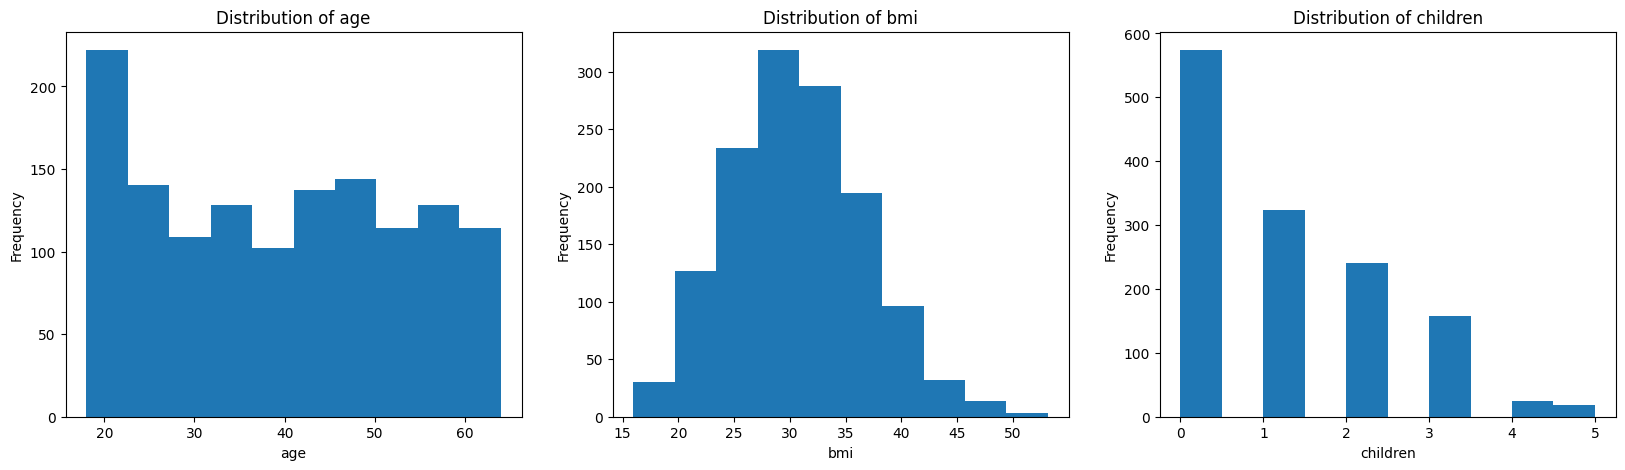

In [9]:
# select numerical cols
num_cols = (
    data.select_dtypes("number")
    .drop(columns="charges")
    .columns
)

# create 3 new subplots for the barcharts
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for idx, ax in enumerate(axs):
  col = num_cols[idx]
  ax.hist(data[col])
  ax.set_xlabel(col)
  ax.set_ylabel("Frequency")
  ax.set_title(f"Distribution of {col}")

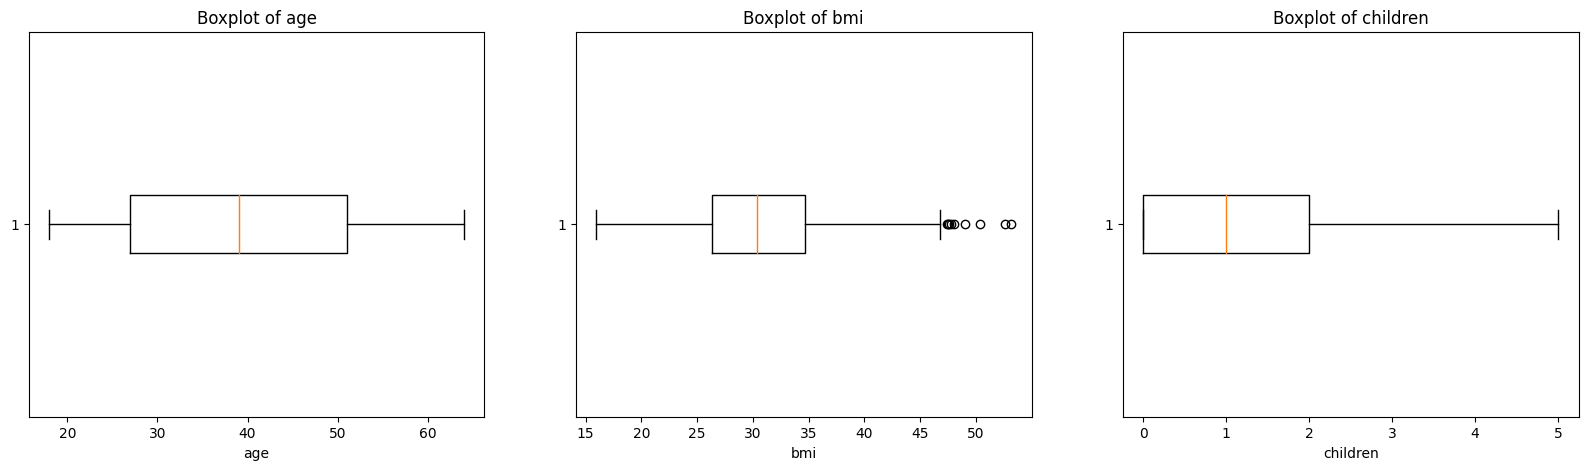

In [10]:
# create 3 subplots for the boxplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for idx, ax in enumerate(axs):
  col = num_cols[idx]
  ax.boxplot(data[col], vert=False)
  ax.set_xlabel(col)
  ax.set_title(f"Boxplot of {col}")

From the above visualizations:
- There are outliers in the distribution of the BMI (normally distributed)
- Children data is skewed to the left i.e. most people have < 3 children
- Age is normally distributed

In [11]:
# removing outliers from bmi
q_99 = data["bmi"].quantile(0.99)
print(f"99th percentile is {q_99}")
top_one_pct = data["bmi"] > q_99
print(f"{data[top_one_pct].count()} observations are above the 99th percentile")

# remove outliers
mask = data["bmi"] <= q_99
data = data[mask]
data.info()


99th percentile is 46.40789999999996
age         14
sex         14
bmi         14
children    14
smoker      14
region      14
charges     14
dtype: int64 observations are above the 99th percentile
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1324 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1324 non-null   int64  
 1   sex       1324 non-null   object 
 2   bmi       1324 non-null   float64
 3   children  1324 non-null   int64  
 4   smoker    1324 non-null   object 
 5   region    1324 non-null   object 
 6   charges   1324 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 82.8+ KB


Text(0.5, 1.0, 'Boxplot of BMI')

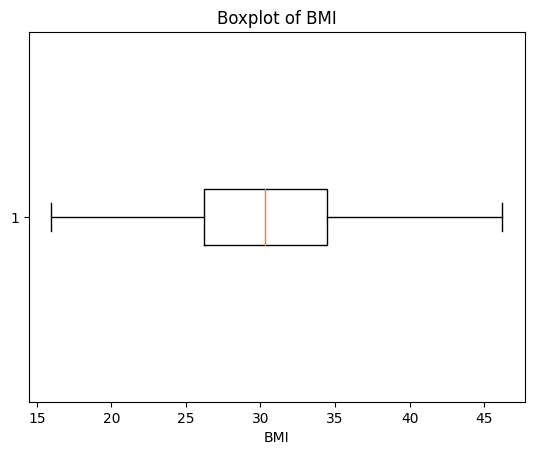

In [12]:
# re-plot the box plot for bmi
plt.boxplot(data["bmi"], vert=False)
plt.xlabel("BMI")
plt.title(f"Boxplot of BMI")

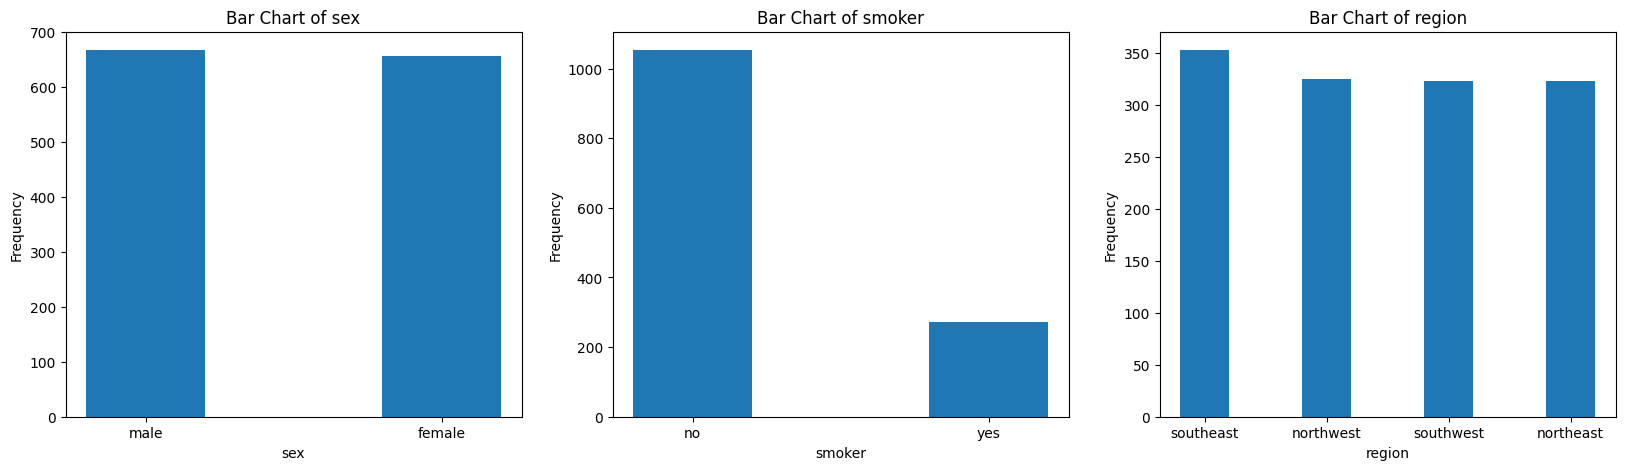

In [13]:
# select the categorical vars
categ_df = data.select_dtypes("object").columns

# create 3 subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
for idx, ax in enumerate(axs):
  col = categ_df[idx]
  df = data[col].value_counts()
  ax.bar(
      x=df.index,
      height=df.values,
      width=0.4,
  )
  ax.set_title(f"Bar Chart of {col}")
  ax.set_xlabel(col)
  ax.set_ylabel("Frequency")

Overall the data is well balanced in terms of sex and region.

C:\Users\Abdulrasheed Nasir\AppData\Local\Temp\ipykernel_18064\2071478055.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


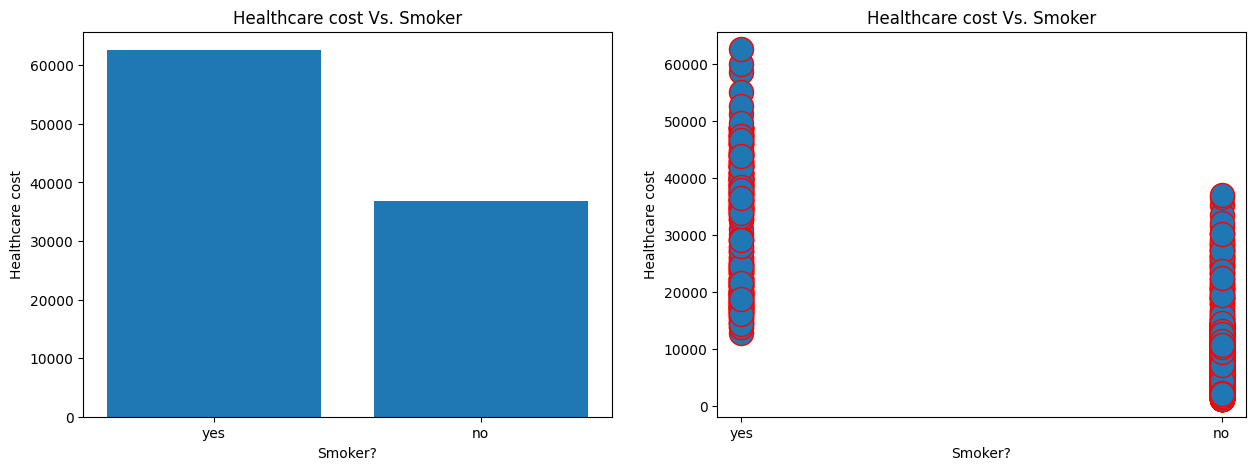

In [14]:
# charges vs smoker bar chart
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(data["smoker"], data["charges"])
axs[0].set_xlabel("Smoker?")
axs[0].set_ylabel("Healthcare cost")
axs[0].set_title("Healthcare cost Vs. Smoker")

axs[1].scatter(data["smoker"], data["charges"], s=300, edgecolors='red')
axs[1].set_xlabel("Smoker?")
axs[1].set_ylabel("Healthcare cost")
axs[1].set_title("Healthcare cost Vs. Smoker")

fig.show();

Smokers seem to have a higher healthcare cost

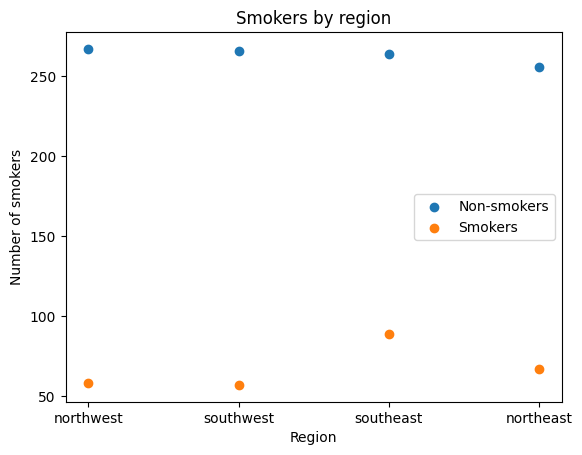

In [15]:
# region vs smoker
reg = data["region"].groupby(data["smoker"])
reg = reg.value_counts()

plt.scatter(x=reg["no"].index, y=reg["no"].values)
plt.scatter(x=reg["yes"].index, y=reg["yes"].values)
plt.legend(("Non-smokers", "Smokers"), loc="center right")
plt.title("Smokers by region")
plt.xlabel("Region")
plt.ylabel("Number of smokers");

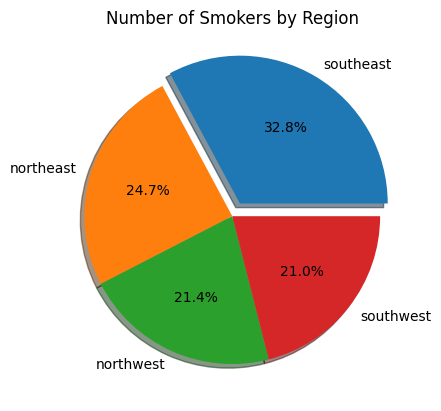

In [16]:
# get all rows with smoker equals yes
smokers = data[data["smoker"] == "yes"]

# get the region from the df and count values
smokers_by_reg = smokers["region"].value_counts()

# create a pie chart
plt.pie(
    smokers_by_reg.values,
    labels=smokers_by_reg.index,
    shadow=True,
    explode=(0.1,0,0,0),
    autopct="%0.1f%%",
)
plt.title("Number of Smokers by Region");

Southeast region have the highest number of smokers

mean male bmi is 30.700982008995503
mean female bmi is 30.248919330289194 



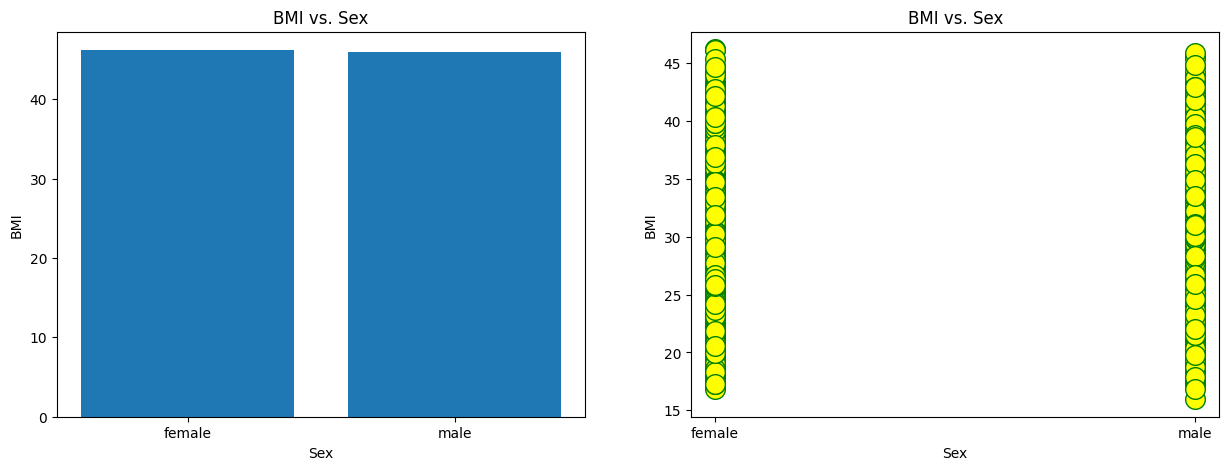

In [17]:
# bmi vs sex
bmi_sex = data["bmi"].groupby(data["sex"])
male, female = bmi_sex.get_group("male"), bmi_sex.get_group("female")
print(f'mean male bmi is {male.mean()}')
print(f'mean female bmi is {female.mean()}', "\n")

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].bar(data["sex"], data["bmi"])
axs[0].set_xlabel("Sex")
axs[0].set_ylabel("BMI")
axs[0].set_title("BMI vs. Sex")

axs[1].scatter(data["sex"], data["bmi"], s=200, c="yellow", edgecolors="green")
axs[1].set_xlabel("Sex")
axs[1].set_ylabel("BMI")
axs[1].set_title("BMI vs. Sex");

There does not seem to be significant difference in BMI distribution among males and females

In [18]:
# region with the most children
children_by_reg = data.groupby("region")["children"].sum()
print("Max: ", children_by_reg.max())

# print the whole series
print(children_by_reg)

Max:  373
region
northeast    337
northwest    373
southeast    367
southwest    367
Name: children, dtype: int64


southeast region has the highest number of children

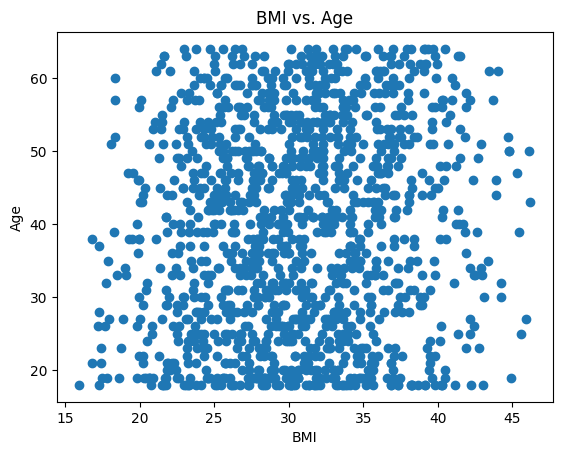

In [19]:
# bmi vs age
plt.scatter(data["bmi"], data["age"])
plt.xlabel("BMI")
plt.ylabel("Age")
plt.title("BMI vs. Age");

There does seem to be a linear relationship between bmi and age. However, they are not strongly correlated

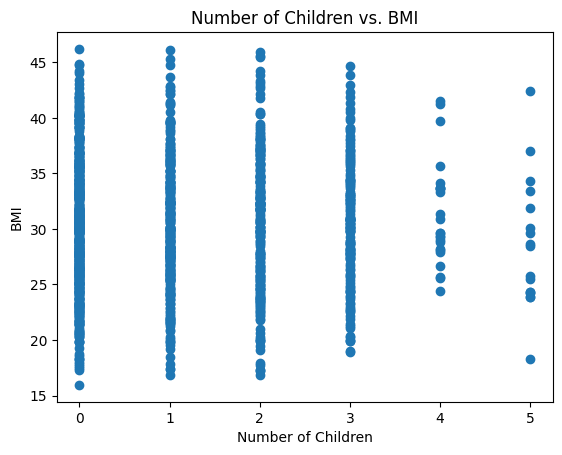

In [20]:
# bmi vs children
plt.scatter(data["children"], data["bmi"])
plt.ylabel("BMI")
plt.xlabel("Number of Children")
plt.title("Number of Children vs. BMI");

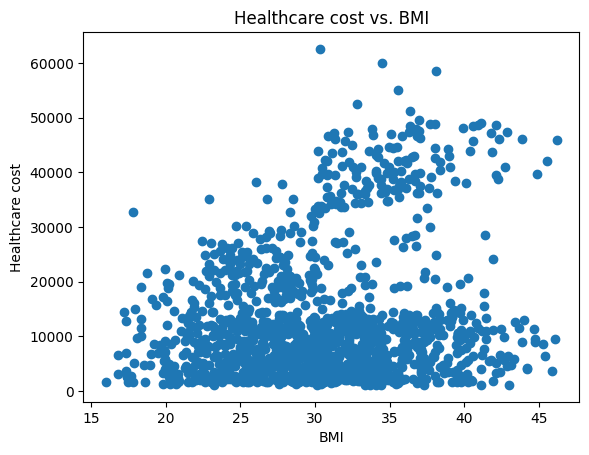

In [21]:
# bmi vs charges
plt.scatter(data["bmi"], data["charges"])
plt.xlabel("BMI")
plt.ylabel("Healthcare cost")
plt.title("Healthcare cost vs. BMI");

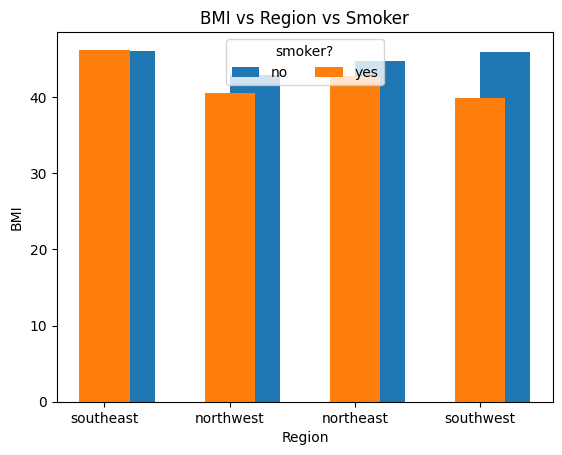

In [22]:
# bmi vs region vs smoker
df = data[["bmi", "region", "smoker"]]
reg = df.groupby("smoker")
regions = ("southeast", "southwest", "northeast", "northwest")
yes = reg.get_group("yes")
no = reg.get_group("no")

plt.bar(no["region"], no["bmi"], align="edge", width=0.4)
plt.bar(x=yes["region"], height=yes["bmi"], width=0.4)
plt.legend(("no", "yes"), title="smoker?", loc="upper center", ncol=2)
plt.xlabel("Region")
plt.ylabel("BMI")
plt.title("BMI vs Region vs Smoker");

C:\Users\Abdulrasheed Nasir\AppData\Local\Temp\ipykernel_18064\2693634663.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


               age       bmi  children   charges
age       1.000000  0.115670  0.040913  0.301754
bmi       0.115670  1.000000  0.004627  0.200882
children  0.040913  0.004627  1.000000  0.071393
charges   0.301754  0.200882  0.071393  1.000000


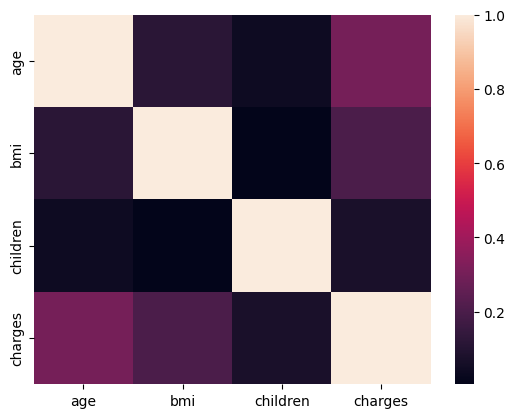

In [23]:
# correlations
corr = data.corr()
print(corr)

sns.heatmap(corr);

- From the heatmap, it can be seen that of all the features, age has the most correlation with healthcare cost, followed by bmi. However the correlation is not strong
- smoking seems to have the most influence on charges
- age and bmi have some correlation with charges

### Data Preprocessing



In [24]:
## encoding
ohe = OneHotEncoder(use_cat_names=True)
data_encoded = ohe.fit_transform(data)
data_encoded.head()

c:\Users\Abdulrasheed Nasir\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\Abdulrasheed Nasir\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\Abdulrasheed Nasir\AppData\Local\Programs\Python\Python39\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():


,age,sex_female,sex_male,bmi,children,smoker_yes,smoker_no,region_southwest,region_southeast,region_northwest,region_northeast,charges
0,19,1,0,27.900,0,1,0,1,0,0,0,16884.92400
1,18,0,1,33.770,1,0,1,0,1,0,0,1725.55230
2,28,0,1,33.000,3,0,1,0,1,0,0,4449.46200
3,33,0,1,22.705,0,0,1,0,0,1,0,21984.47061
4,32,0,1,28.880,0,0,1,0,0,1,0,3866.85520


In [25]:
# split data
features = data_encoded.drop(columns="charges")
target = data_encoded["charges"]

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=42)

In [26]:
# normalize data
scaler = MinMaxScaler()

X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

## Training and testing models

In [27]:
# cross validation
models = [LinearRegression, Ridge, SVR, DecisionTreeRegressor, RandomForestRegressor]
for model in models:
  regressor = model()
  scores = cross_val_score(regressor, X_train_std, y_train, cv=5)
  print(f"Accuracy score for {model.__name__} is {scores.mean()}")

Accuracy score for LinearRegression is 0.747061430655319
Accuracy score for Ridge is 0.7471170951663183
Accuracy score for SVR is -0.10255047611723964
Accuracy score for DecisionTreeRegressor is 0.6955525095739347
Accuracy score for RandomForestRegressor is 0.8392419389601529


Random forest regressor have the highest average accuracy score

### Tuning the hyperparameters
- n_estimators: number of trees in the forest
- max_depth
- max_features
- min_sample_leaf
- min_sample_split

In [30]:
# hyper parameter tuning
param_grid = {
    "n_estimators": [n * 100 for n in range(2, 21)],
    "max_depth": [n * 10 for n in range(1, 11)] + [None],
    "max_features": [1.0,"sqrt"],
    "min_samples_split": [2, 4, 6],
    "min_samples_leaf": [1, 2, 5, 10]
}

model = RandomForestRegressor() # base model
rand_search = RandomizedSearchCV(model, param_grid, cv=5, verbose=1, n_iter=100, n_jobs=-1)
rand_search.fit(X_train, y_train)

print(rand_search.best_score_)
rand_search.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0.8604500436596011


{'n_estimators': 400,
 'min_samples_split': 6,
 'min_samples_leaf': 10,
 'max_features': 1.0,
 'max_depth': 90}

In [31]:
cv_results = pd.DataFrame(rand_search.cv_results_)

# display top 5
top_5 = cv_results.sort_values("mean_test_score", ascending=False)[["params", "mean_test_score"]].head()
print(top_5)


                                               params  mean_test_score
84  {'n_estimators': 400, 'min_samples_split': 6, ...         0.860450
2   {'n_estimators': 500, 'min_samples_split': 4, ...         0.860371
14  {'n_estimators': 600, 'min_samples_split': 4, ...         0.860355
11  {'n_estimators': 1200, 'min_samples_split': 4,...         0.860333
46  {'n_estimators': 400, 'min_samples_split': 2, ...         0.860290


In [32]:
# training

# extract the best param from random search cv
n_est, msp, msl, mf, md = rand_search.best_params_.values()

# instantiate model with best params
model = RandomForestRegressor(n_estimators=n_est,
                            min_samples_split=msp,
                            min_samples_leaf=msl,
                            max_features=mf,
                            max_depth=md
                          )
# train model
model.fit(X_train_std, y_train)


RandomForestRegressor(max_depth=90, min_samples_leaf=10, min_samples_split=6,
                      n_estimators=400)

In [35]:
# testing the model
print(f"mean for y_train: {y_train.mean()}")
print(f"mean for y_test: {y_test.mean()}\n")

# metrics using training data
y_pred_train = model.predict(X_train_std)
mae_base = mean_absolute_error(y_train, y_pred_train)
rmse_base = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"MAE for training data: {mae_base}")
print(f"RMSE for training data: {rmse_base}\n")

# predict
y_pred = model.predict(X_test_std)

# metrics for test data
mae_pred = mean_absolute_error(y_test, y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"MAE for test data: {mae_pred}")
print(f"RMSE for test data: {rmse_test}")  

mean for y_train: 13191.228458478348
mean for y_test: 13359.88266670695

MAE for training data: 2153.8638403501363
RMSE for training data: 3909.2979758262777

MAE for test data: 2549.4903304641016
RMSE for test data: 4737.775538238622


### Conclusion

- Random forest regressor performed best with the dataset
- SVC had the worst performance
- Age and bmi have some correlation with charges